Gaussian Process Regression

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize,basinhopping,shgo
from numpy.linalg import cholesky
from numpy.random import normal
import traceback
from scipy.spatial.distance import euclidean
from scipy.linalg import solve_triangular
from random import uniform
from scipy.stats import norm

In [3]:
# global noise control
noise = 1e-6 # numerical convenience to avoid singular matrix

In [4]:
# RBF + WHITENOISE KERNEL
def cov_rbf(X1,X2,gamma=1, noise=noise):
    """
    args:
    X1,X2: list of array
    gamma: free parameter of RBF kernel, see https://scikit-learn.org/stable/modules/metrics.html#rbf-kernel 
    noise: std of Gaussian white noise
    """
    N1, N2 = len(X1), len(X2)
    cov = np.zeros([N1,N2])
    for i in range(N1):
        x1 = X1[i]
        for j in range(N2):
            x2 = X2[j]
            # RBF
            cov[i,j] = np.exp(-gamma*euclidean(x1,x2)**2)
    white_kernel = np.eye(N1,N2)*noise**2
    return cov + white_kernel


In [5]:
def objective(x, noise = noise):
    return x * np.sin(x) + normal(loc=0.0, scale=noise)


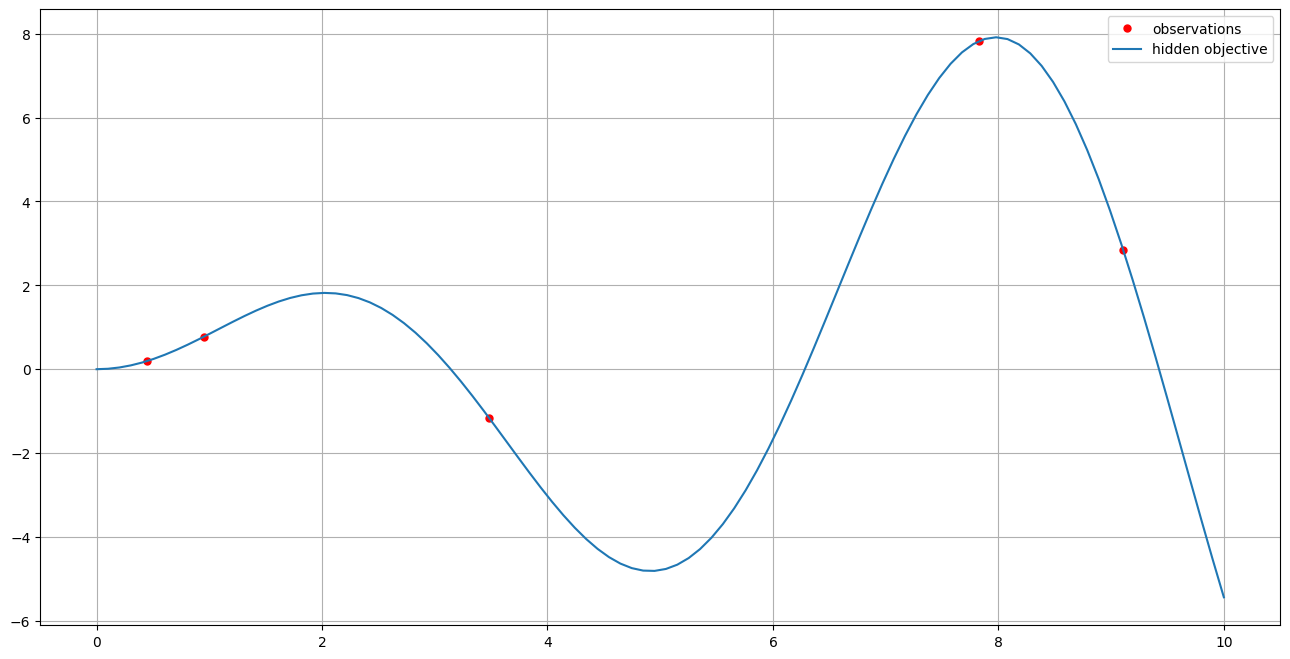

In [6]:
# OBSERVATIONS
minX, maxX = 0,10

x_observed = np.array(sorted(maxX*np.random.random(size=5)))
y_observed = np.array(objective(x_observed))

plt.figure(figsize=(16,8))
x_mesh = np.linspace(minX, maxX, 100)
y_mesh = objective(x_mesh)

plt.plot(x_observed, y_observed, 'r.', markersize=10, label='observations')
plt.plot(x_mesh,y_mesh, label='hidden objective')
plt.legend()
plt.grid()

In [7]:
def dtrtri(K):
    '''
    invert covariance matrix with Cholesky decomposition
    args:
    K: symmetric positive-definite matrix
    returns:
    L: Cholesky decomposition, lower triangular
    K_inv: inverse of K
    '''
    L = cholesky(K)
    L_inv = solve_triangular(L, np.identity(L.shape[0]),lower=True) # should be dtrtri, complex to O(N**2)
    K_inv = np.dot(L_inv.T,L_inv)
    return L, K_inv

In [8]:
def negative_log_likelihood(theta,observations):
    '''
    negative log likelihood of observations
    args:
    - theta: gamma and noise, free parameters of the kernel function
    - observations: (x_observed, y_observed)
    returns: 
    - nll: negative log likelihood of the observations
    '''
    gamma,noise = theta
    x_observed,y_observed = observations
    K = cov_rbf(x_observed, x_observed, gamma=gamma, noise=noise)
    L,K_inv = dtrtri(K)
    # negative log likelihood
    nll = 0.5*(y_observed.T.dot(K_inv).dot(y_observed) + \
               len(x_observed) * np.log(2*np.pi) + \
                     2*np.sum(np.log(np.diagonal(L))))
    return nll


In [9]:
observations = (x_observed,y_observed)
kernel_res = minimize(negative_log_likelihood, x0=[1,noise], args=(observations,), bounds=[(1e-5, None), (noise, noise)])
gamma_opt,noise_opt = kernel_res.x
gamma_opt,noise_opt

ValueError: Input vector should be 1-D.